In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
pip install -r requirements.txt

ERROR: Could not find a version that satisfies the requirement opencv-contrib-python==3.4.2.17 (from versions: 3.4.11.45, 3.4.13.47, 3.4.14.51, 3.4.14.53, 3.4.15.55, 3.4.16.59, 3.4.17.61, 3.4.17.63, 3.4.18.65, 4.4.0.46, 4.5.1.48, 4.5.2.52, 4.5.2.54, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.62, 4.5.5.64, 4.6.0.66)
ERROR: No matching distribution found for opencv-contrib-python==3.4.2.17

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached opencv_python-4.6.0.66-cp36-abi3-win_amd64.whl (35.6 MB)


In [9]:
%pip install opencv-contrib-python==3.4.11.45

     --------------------------------------- 37.4/37.4 MB 17.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import cv2
import numpy as np

image shape: (410, 615, 3)


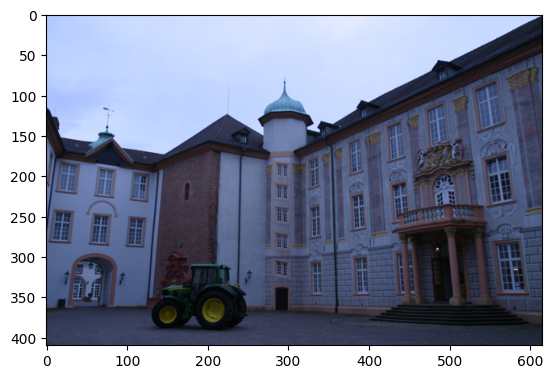

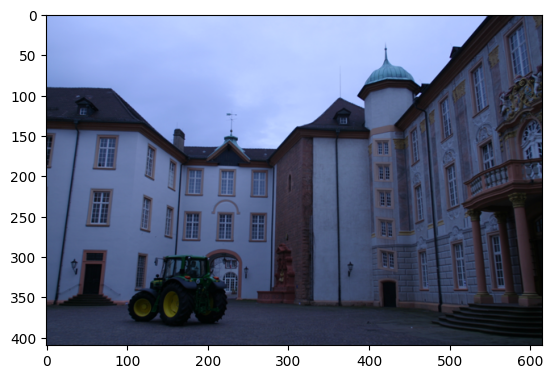

In [11]:
# load the images
im_left = cv2.imread('../data/0014_2.png')
print("image shape:", im_left.shape)
plt.imshow(im_left[:, :, ::-1])
plt.figure()
im_right = cv2.imread('../data/0017_2.png')
plt.imshow(im_right[:, :, ::-1])
images = [im_left, im_right]

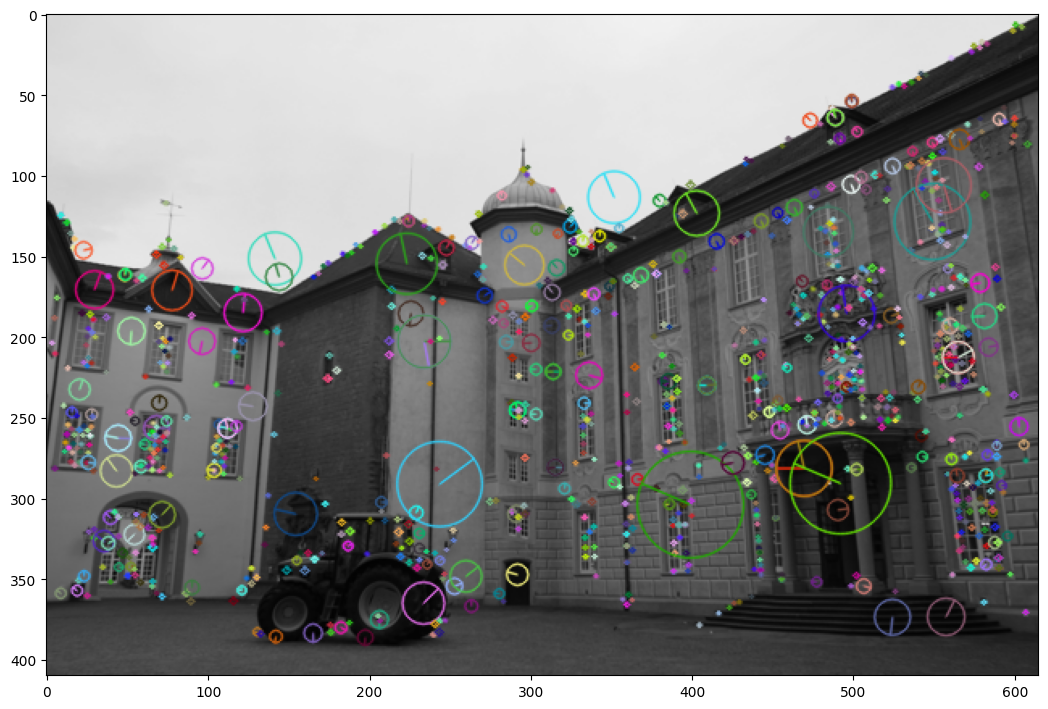

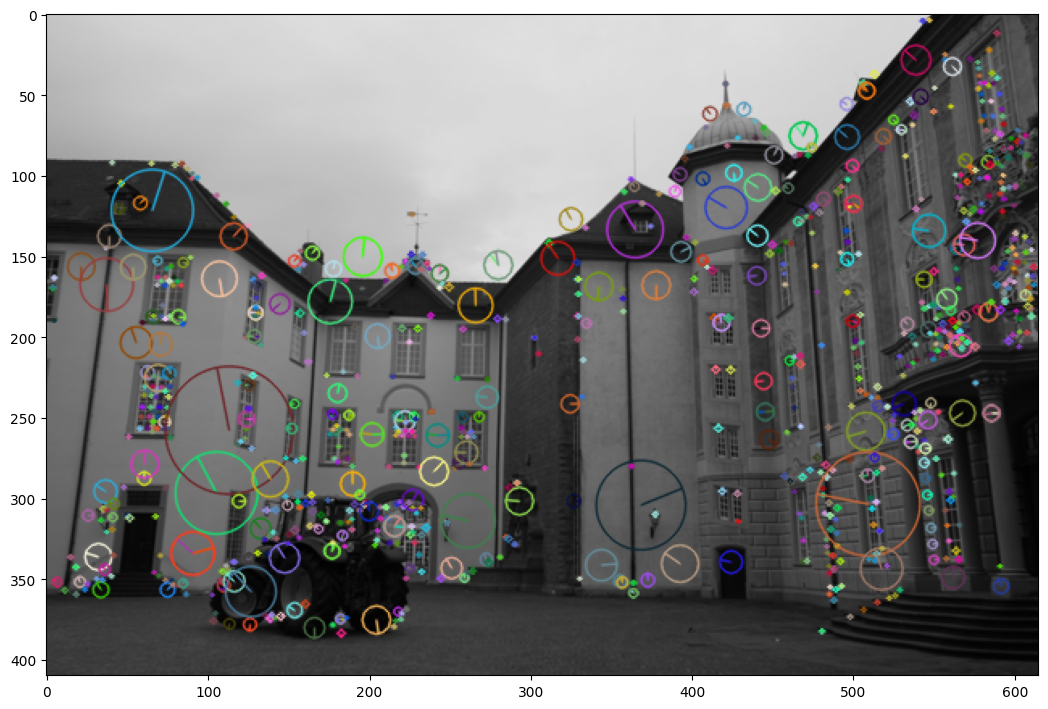

In [12]:
""" Detects SIFT features in all of the images
"""
keypoints = []
descriptions = []
for im in images:
  gray= cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)

  sift = cv2.xfeatures2d.SIFT_create()
  kp, des = sift.detectAndCompute(gray,None)

  keypoints.append(kp)
  descriptions.append(des)

  plt.figure(figsize=(6.4*2, 4.8*2))
  out_im = cv2.drawKeypoints(gray,kp, gray, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

  plt.imshow(out_im)

num matches 393


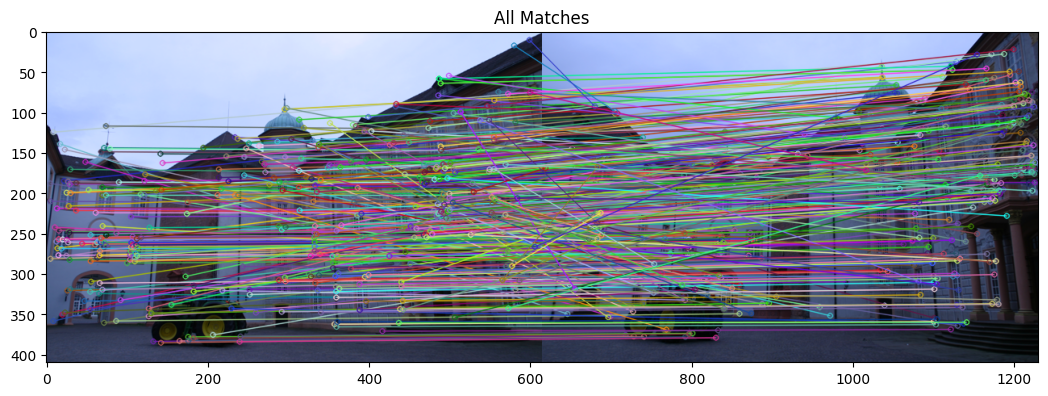

In [13]:
""" Matches the detected keypoints between the images
"""

bf = cv2.BFMatcher(crossCheck=True)
matches = bf.match(descriptions[0], descriptions[1])

print("num matches", len(matches))


matched_image = cv2.drawMatches(images[0][:, :, ::-1], keypoints[0], images[1][:, :, ::-1], keypoints[1], matches, None, flags=2)
plt.figure(figsize=(6.4*2, 4.8*2))
plt.title("All Matches")
plt.imshow(matched_image)


In [14]:
""" Compute calibrated coordinates
"""

# For the satsok castle images
f1 = f2 = 552
u0 = 307.5
v0 = 205

K = np.array([[f1, 0, u0],
              [0, f2, v0],
              [0, 0, 1]])


uncalibrated_1 = [[keypoints[0][match.queryIdx].pt[0], keypoints[0][match.queryIdx].pt[1], 1] for match in matches]
uncalibrated_2 = [[keypoints[1][match.trainIdx].pt[0], keypoints[1][match.trainIdx].pt[1], 1] for match in matches]

uncalibrated_1 = np.array(uncalibrated_1).T
uncalibrated_2 = np.array(uncalibrated_2).T

k_inv = np.linalg.inv(K)

calibrated_1 = np.matmul(k_inv, uncalibrated_1).T
calibrated_2 = np.matmul(k_inv, uncalibrated_2).T


In [19]:
from lse import least_squares_estimation
E_least = least_squares_estimation(calibrated_1, calibrated_2)
print("E least", E_least)

(393, 9)
E least [[ 0.03483375  0.19532623  0.00230569]
 [ 0.12138756  0.96929548 -0.08251122]
 [-0.48165889 -0.00994676 -0.87604678]]


E_ransac [[-0.00240034 -0.07852153  0.02252053]
 [ 0.52963285  0.01934117 -0.84772222]
 [-0.11732427  0.98877018 -0.04870297]]
Num inliers (191,)


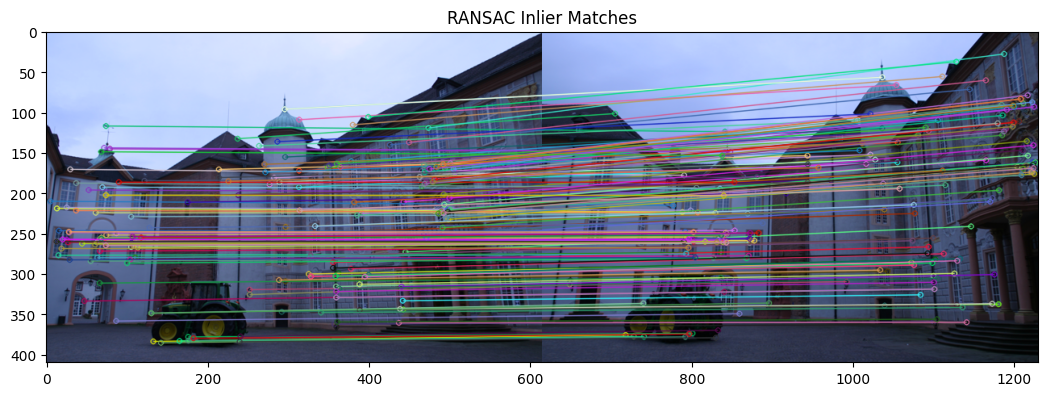

In [61]:
from ransac import ransac_estimator

# running this cell will take a while!!!

E_ransac, inliers = ransac_estimator(calibrated_1, calibrated_2)
print("E_ransac", E_ransac)
print("Num inliers", inliers.shape)

inlier_matches = [matches[i] for i in inliers]

matched_image = cv2.drawMatches(images[0][:, :, ::-1],
                                keypoints[0],
                                images[1][:, :, ::-1],
                                keypoints[1],
                                inlier_matches, None, flags=2)
plt.figure(figsize=(6.4*2, 4.8*2))
plt.title("RANSAC Inlier Matches")
plt.imshow(matched_image)

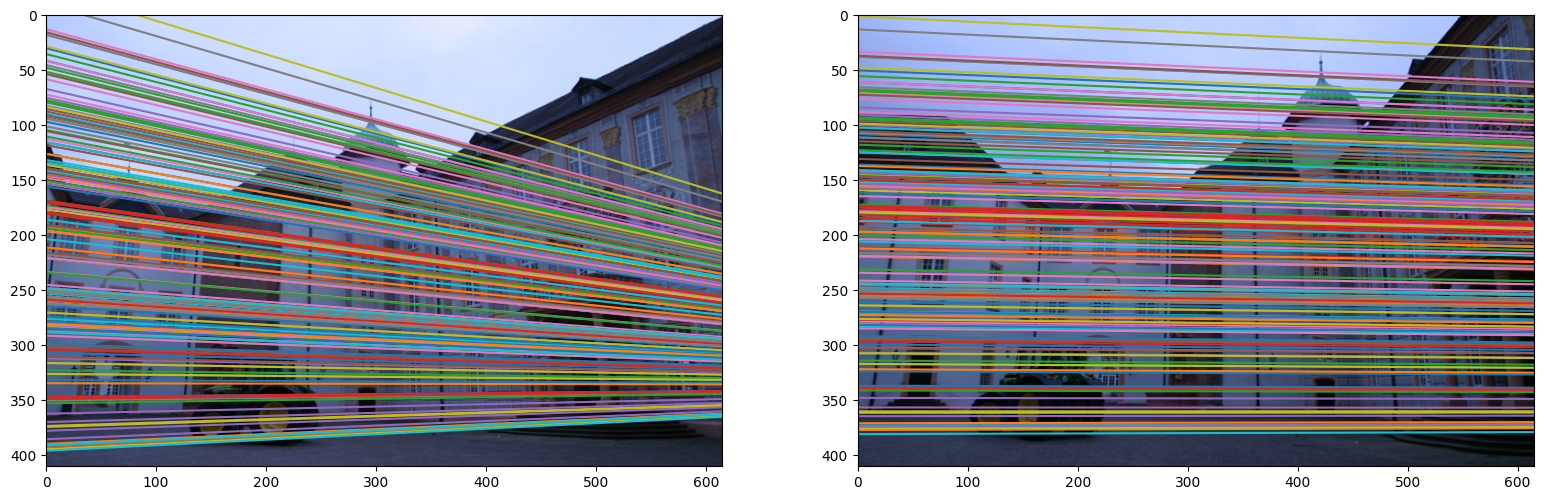

In [71]:
from plot_epi import plot_epipolar_lines

uncalibrated_inliers_1 = [[keypoints[0][match.queryIdx].pt[0], keypoints[0][match.queryIdx].pt[1], 1] for match in inlier_matches]
uncalibrated_inliers_2 = [[keypoints[1][match.trainIdx].pt[0], keypoints[1][match.trainIdx].pt[1], 1] for match in inlier_matches]
uncalibrated_inliers_1 = np.array(uncalibrated_inliers_1).T
uncalibrated_inliers_2 = np.array(uncalibrated_inliers_2).T

plot_epipolar_lines(images[0], images[1], uncalibrated_inliers_1, uncalibrated_inliers_2, E_ransac, K)

In [84]:
from pose import pose_candidates_from_E

transform_candidates = pose_candidates_from_E(E_ransac)
print("transform_candidates", transform_candidates)
for c in transform_candidates:
  print(np.linalg.det(c['R']))

np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]]).T

transform_candidates [{'T': array([0.99665512, 0.02195459, 0.07871825]), 'R': array([[-0.88152806, -0.10506755, -0.4602924 ],
       [ 0.09829949, -0.99440305,  0.03872698],
       [ 0.46178512,  0.01110759, -0.88692228]])}, {'T': array([0.99665512, 0.02195459, 0.07871825]), 'R': array([[-0.79299291, -0.14543863, -0.59161631],
       [-0.13518629,  0.98888484, -0.06189871],
       [-0.59404286, -0.03089318,  0.80383997]])}, {'T': array([-0.99665512, -0.02195459, -0.07871825]), 'R': array([[-0.88152806, -0.10506755, -0.4602924 ],
       [ 0.09829949, -0.99440305,  0.03872698],
       [ 0.46178512,  0.01110759, -0.88692228]])}, {'T': array([-0.99665512, -0.02195459, -0.07871825]), 'R': array([[-0.79299291, -0.14543863, -0.59161631],
       [-0.13518629,  0.98888484, -0.06189871],
       [-0.59404286, -0.03089318,  0.80383997]])}]
-1.0000000000000002
-1.0000000000000004
-1.0000000000000002
-1.0000000000000004


array([[ 0,  1,  0],
       [-1,  0,  0],
       [ 0,  0,  1]])

In [85]:
def plot_reconstruction(P1, P2, T, R):
  P1trans = (R @ P1.T).T + T

  plt.figure(figsize=(6.4*2, 4.8*2))
  ax = plt.axes()
  ax.set_xlabel('x')
  ax.set_ylabel('z')

  for i in range(P1.shape[0]):
    plt.plot([0, P2[i, 0]], [0, P2[i, 2]], 'bs-')
    plt.plot([T[0], P1trans[i, 0]], [T[2], P1trans[i, 2]], 'ro-')
  plt.plot([0], [0], 'bs')
  plt.plot([T[0]], [T[2]], 'ro')

best 1 (393,)
best 352 (393,)
not best 0
not best 40


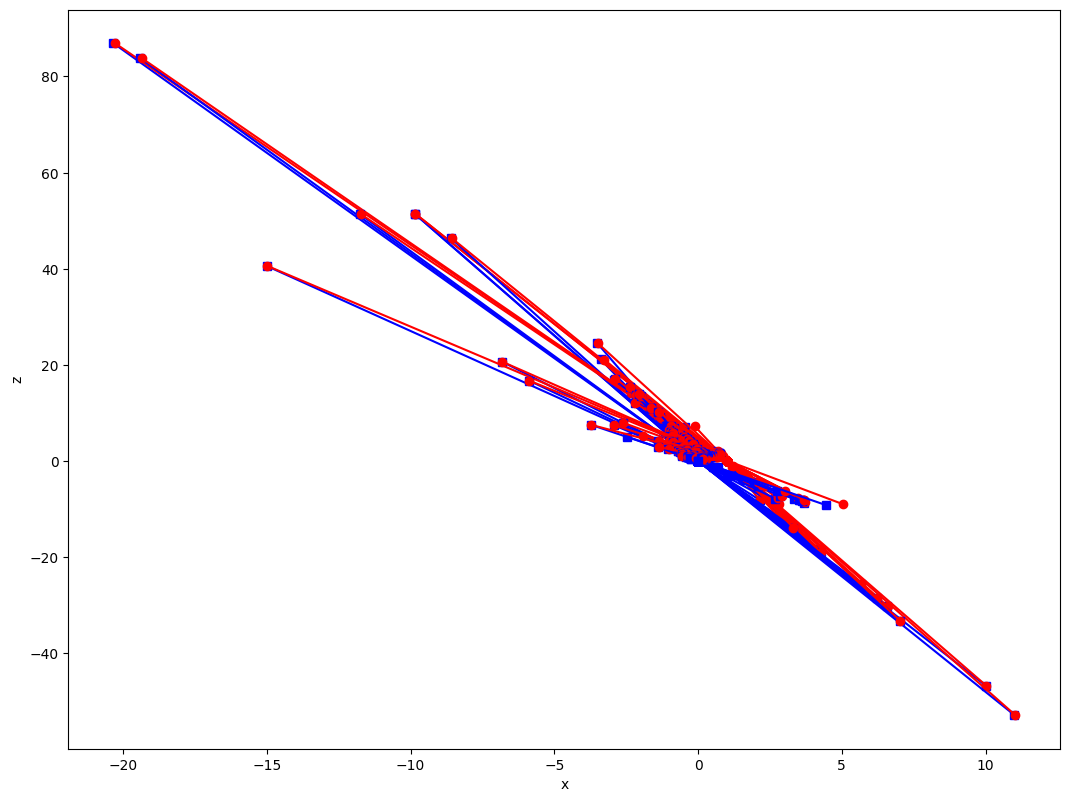

In [98]:
from recon3d import reconstruct3D 

P1, P2, T, R = reconstruct3D(transform_candidates, calibrated_1, calibrated_2)

plot_reconstruction(P1, P2, T, R)

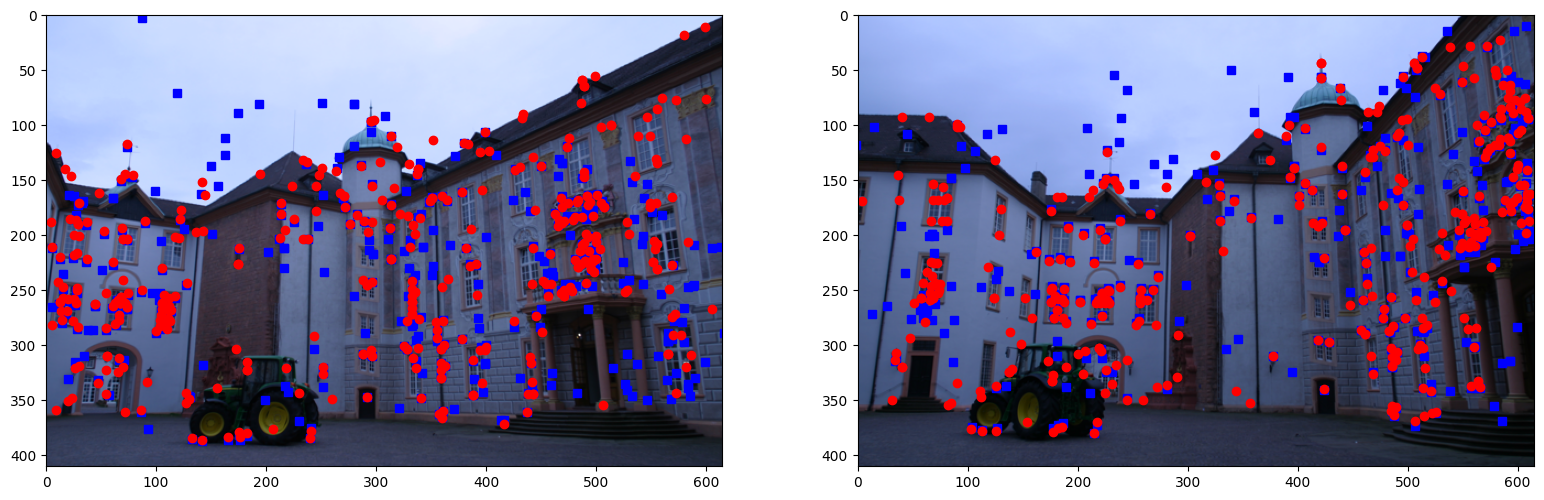

In [138]:
from show_reproj import show_reprojections

show_reprojections(images[0], images[1], uncalibrated_1, uncalibrated_2, P1, P2, K, T, R)